(d_vector_crs_intro)=

----------------

```{admonition} Learning Objectives
- How to assign a projection to vector data
- How to reproject vector data
```
```{admonition} Review
* [Understanding CRS codes](d_understand_crs_codes.md)
* [Creating Points, Lines, Polygons](e_new_vectors.md)
```
----------------

# Vector Coordinate Reference Systems (CRS)
When it comes to coordinate reference systems points, lines and polygons are convenient because each point or node has an assigned coordinate pair (x,y). The only trick then is to know how those coordinates relate to the coordinate space, or location on the ground. 

## Define a Projection for Points, Lines, Polygons
When a point, line or polyon is created each point or node has two coordinates `x` and `y`. The location of these two points on the ground will change wildly between projections. The coordinate pair (0,0) might mean a location just off shore from Ghana with WGS84 LatLon, or in the middle of the Pacific ocean in another. 

Let's take a look at the example of a polygon with coordinates (0,45),(5,45),(5,40),(0,40) below. In the left pane we can see that, although we have the polygon's node coordinates, we don't know where they are located! This is because no coordinate reference system has been assigned to it. Could be in outer space for all we know. On the right, we can see that we have assigned it WGS84 geographic lat lon i.e. `EPSG:4326`. Suddenly the coordinates make sense, because we know how they relate to locations on the ground.   

```{figure} ../_static/d_crs/d_crs_assigned.png
:name: Example of assigning a coordinate reference system
:width: 700px
Example of assigning a coordinate reference system
```
Every time we create vector data (or receive it from someone else), we need to make sure that a projection is assigned to it. 

The following demonstrates how to

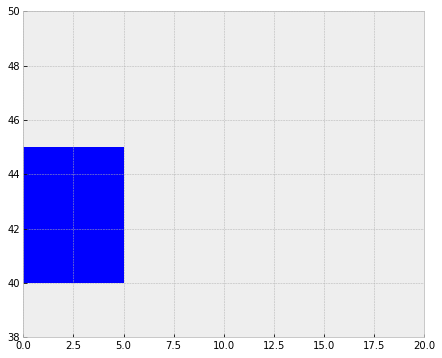

In [1]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
plt.style.use('bmh')  

a_square = {'name': ['Washington\n(38.90, -77.03)' ], 
     'geometry': [Polygon([Point(0,45), Point(5,45), Point(5,40), Point(0,40)])]}

# create a dataframe from the nodes and assign the CRS
gdf_square = gpd.GeoDataFrame(a_square, crs="EPSG:4326")  
fig, ax = plt.subplots(figsize=(12, 6))
gdf_square.plot(ax=ax)
plt.ylim(38, 50)
plt.xlim(0, 20)
plt.show()

```{note}
Take a moment to review proj4 string and EPSG codes [here](d_understand_crs_codes.md)
```
 
## Reproject Points, Lines, Polygons
Once a projection is assigned we often have to 'reproject' it to another one. Reprojection entails using a set of formulas to convert (x,y) stored in latitude and longitude into another coordinate space. This entails a two step process. 

Looking at the example below, we will move from Sinosoidal to Hobo-Dyer. The first step however is to use the "inverse equation" to convert coordinate pairs from Sinosoidal back to lat lon, and the use the forward equation to convert lat lon into the Hobo-Dyer coordinate space. 

```{figure} ../_static/d_crs/d_reprojection_example.jpg
:name: Reprojecting vectors with inverse and forward equations
:width: 500px
Reprojecting vectors with inverse and forward equations
```

<!-- Affine transformations allows us to use simple systems of linear equations to manipulate any point or set of points. It allows us to move, stretch, or even rotate a point or set of points. In this case it is used to move and reshape vector data (point, lines, polygons). In this case we will learn how affine transforms are used to reproject data. -->

These 'forward' and 'inverse' equations can be simple or complex. To make things easy to understand lets look at the example of reprojecting from proj4 code `+proj=longlat +datum=WGS84` to `+proj=longlat +datum=WGS84 +lon_0=-10`, where `+lon_0=-10` just moves the prime meridian 10 degrees west (west is negative). Because we are already in latitude and longitude we can ignore the 'inverse' equation and just look at the 'forward' equation. 

In this case the 'forward' equation is very simple:

$$
x = x + 10 
$$

$$
y = y
$$

As result the polygon remains in the same location, but in the 'new' projection longitude values are now all 10 degrees higher. 

```{figure} ../_static/d_crs/d_europe_translate_vector.png
:name: Reprojecting by moving the prime meridian west
:width: 500px
Reprojecting by moving the prime meridian west
```
Most 'forward' and 'inverse' equations are non-linear and more complex. Take for instance the Gall-Peters forward projection equations are shown below: 

$$
x=\frac {R\pi \lambda \cos 45^{\circ }}{180^{\circ }}
$$

$$
y={\frac {R\sin \varphi }{\cos 45^{\circ }}} 
$$

where $\lambda$ is the longitude from the central meridian in degrees, $\varphi$ is the latitude, and R is the radius of the globe used as the model of the earth for projection. Luckily computers make all these calculation quick and easy. 

Refering back to our previous example, let's use geopandas to move the prime meridian 10 degrees west:

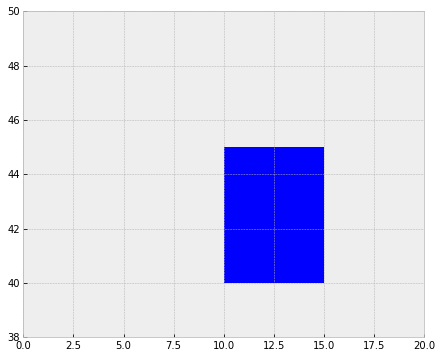

In [2]:
# reproject the data
gdf_square_10w = gdf_square.to_crs("+proj=longlat +datum=WGS84 +lon_0=-10")

fig, ax = plt.subplots(figsize=(12, 6))
gdf_square_10w.plot(ax=ax)
plt.ylim(38, 50)
plt.xlim(0, 20)
plt.show()

Note the shift in coordinates along x by 10 degrees west.

<!--
https://kartoweb.itc.nl/geometrics/Coordinate%20transformations/coordtrans.html

 https://geopandas.org/gallery/plotting_with_geoplot.html

https://geocompr.robinlovelace.net/geometric-operations.html
 In this section we will learn how to reproject vector data:


 Affine transformation is any transformation that preserves lines and parallelism. However, angles or length are not necessarily preserved. Affine transformations include, among others, shifting (translation), scaling and rotation. Additionally, it is possible to use any combination of these. Affine transformations are an essential part of geocomputation. For example, shifting is needed for labels placement, scaling is used in non-contiguous area cartograms (see Section 8.6), and many affine transformations are applied when reprojecting or improving the geometry that was created based on a distorted or wrongly projected map. The sf package implements affine transformation for objects of classes sfg and sfc.

nz_sfc = st_geometry(nz)

Shifting moves every point by the same distance in map units. It could be done by adding a numerical vector to a vector object. For example, the code below shifts all y-coordinates by 100,000 meters to the north, but leaves the x-coordinates untouched (left panel of Figure 5.5).

nz_shift = nz_sfc + c(0, 100000)

Scaling enlarges or shrinks objects by a factor. It can be applied either globally or locally. Global scaling increases or decreases all coordinates values in relation to the origin coordinates, while keeping all geometries topological relations intact. It can be done by subtraction or multiplication of asfg or sfc object.

Local scaling treats geometries independently and requires points around which geometries are going to be scaled, e.g., centroids. In the example below, each geometry is shrunk by a factor of two around the centroids (middle panel in Figure 5.5). To achieve that, each object is firstly shifted in a way that its center has coordinates of 0, 0 ((nz_sfc - nz_centroid_sfc)). Next, the sizes of the geometries are reduced by half (* 0.5). Finally, each object’s centroid is moved back to the input data coordinates (+ nz_centroid_sfc).

nz_centroid_sfc = st_centroid(nz_sfc)
nz_scale = (nz_sfc - nz_centroid_sfc) * 0.5 + nz_centroid_sfc

Rotation of two-dimensional coordinates requires a rotation matrix:

R=[cosθ−sinθsinθcosθ]

It rotates points in a clockwise direction. The rotation matrix can be implemented in R as:

rotation = function(a){
  r = a * pi / 180 #degrees to radians
  matrix(c(cos(r), sin(r), -sin(r), cos(r)), nrow = 2, ncol = 2)
} 

The rotation function accepts one argument a - a rotation angle in degrees. Rotation could be done around selected points, such as centroids (right panel of Figure 5.5). See vignette("sf3") for more examples.

nz_rotate = (nz_sfc - nz_centroid_sfc) * rotation(30) + nz_centroid_sfc

Illustrations of affine transformations: shift, scale and rotate.

FIGURE 5.5: Illustrations of affine transformations: shift, scale and rotate.

Finally, the newly created geometries can replace the old ones with the st_set_geometry() function:

nz_scale_sf = st_set_geometry(nz, nz_scale) -->